# Clasificación de valoraciones de Google Play

## Librerías utilizadas

In [0]:
!pip install tensorflow-gpu==2.0.0

     |████████████████████████████████| 380.8MB 45kB/s 
     |████████████████████████████████| 450kB 41.9MB/s 
     |████████████████████████████████| 3.8MB 27.5MB/s 
     |████████████████████████████████| 81kB 9.4MB/s 
ERROR: tensorflow 1.15.0 has requirement tensorboard<1.16.0,>=1.15.0, but you'll have tensorboard 2.0.1 which is incompatible.
ERROR: tensorflow 1.15.0 has requirement tensorflow-estimator==1.15.1, but you'll have tensorflow-estimator 2.0.1 which is incompatible.
ERROR: tensorboard 2.0.1 has requirement grpcio>=1.24.3, but you'll have grpcio 1.15.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement google-auth~=1.4.0, but you'll have google-auth 1.7.1 which is incompatible.
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1
  Found existing installation: google-auth 1.4.2
    Uninstalling google-auth-1.4.2:
      Successfully uninstalled googl

In [0]:
import pandas
import tensorflow as tf
import re
import nltk
import numpy

from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords

nltk.download('stopwords')

tf.__version__

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


'2.0.0'

## Carga de datos


Para poder cargar los datos se puede hacer mediante dos vías. La primera es subir el archivo `csv` en el mismo entorno de ejecución (Barra lateral > Archivos > Subir). Con este modo, cada vez que abandonemos el cuaderno se borrará. Por tanto, usaremos la segunda manera: cargarlo de Google Drive. Nos pedirá que abramos un link e introduzcamos el código que aparece en ese link.


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Con el archivo `googleplaystore_user_reviews.csv` subido en nuestro Google Play, podemos proceder a la lectura y carga del dataframe. Si se tiene en otra carpeta, la ruta `/content/drive/My Drive/` debe mantenerse ya que es la básica de Drive.


In [0]:
dataframe = pandas.read_csv('/content/drive/My Drive/Curso de TensorFlow 2.0/Notebooks del Curso/Ejercicios/googleplaystore_user_reviews.csv')

En este caso, el fichero `googleplaystore_user_reviews.csv` se encuentra en la raíz del Drive. Para asegurarnos que está bien cargado haremos un `head` del dataframe:


In [0]:
dataframe.head()

,App,Translated_Review,Sentiment,Sentiment_Polarity,Sentiment_Subjectivity
0,10 Best Foods for You,I like eat delicious food. That's I'm cooking ...,Positive,1.00,0.533333
1,10 Best Foods for You,This help eating healthy exercise regular basis,Positive,0.25,0.288462
2,10 Best Foods for You,NaN,NaN,NaN,NaN
3,10 Best Foods for You,Works great especially going grocery store,Positive,0.40,0.875000
4,10 Best Foods for You,Best idea us,Positive,1.00,0.300000


In [0]:
dataframe.tail()

,App,Translated_Review,Sentiment,Sentiment_Polarity,Sentiment_Subjectivity
64290,Houzz Interior Design Ideas,NaN,NaN,NaN,NaN
64291,Houzz Interior Design Ideas,NaN,NaN,NaN,NaN
64292,Houzz Interior Design Ideas,NaN,NaN,NaN,NaN
64293,Houzz Interior Design Ideas,NaN,NaN,NaN,NaN
64294,Houzz Interior Design Ideas,NaN,NaN,NaN,NaN


## Pre-procesado de datos

Antes de preparar los datos para que sean aptos para la entrada de la red neuronal, se eliminarán aquellas filas que contengan `NaN`.

In [0]:
dataframe = dataframe.dropna()
dataframe.head()

,App,Translated_Review,Sentiment,Sentiment_Polarity,Sentiment_Subjectivity
0,10 Best Foods for You,I like eat delicious food. That's I'm cooking ...,Positive,1.00,0.533333
1,10 Best Foods for You,This help eating healthy exercise regular basis,Positive,0.25,0.288462
3,10 Best Foods for You,Works great especially going grocery store,Positive,0.40,0.875000
4,10 Best Foods for You,Best idea us,Positive,1.00,0.300000
5,10 Best Foods for You,Best way,Positive,1.00,0.300000


Antes de proceder al procesamiento de los datos, se puede realizar una exploración previa de las frecuencias de los sentimientos mediante un diagrama de barras:

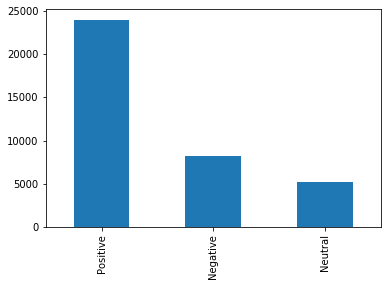

In [0]:
dataframe['Sentiment'].value_counts().plot(kind = 'bar')

Ahora, a partir del mensaje se quiere predecir el tipo de sentimiento. Para ello, sacaremos esas dos columnas del dataframe:

In [0]:
dataframe = dataframe[['Translated_Review','Sentiment']]
dataframe.head()

,Translated_Review,Sentiment
0,I like eat delicious food. That's I'm cooking ...,Positive
1,This help eating healthy exercise regular basis,Positive
3,Works great especially going grocery store,Positive
4,Best idea us,Positive
5,Best way,Positive


En principio, tenemos tres clases, de manera que podemos optar por estas dos vías:

*   Considerar una clasificación binaria. Eliminaremos del dataframe aquellas muestras que pertenezcan a la categoría `Neutral`. Convertiremos el vector `Sentiment` en 0 o 1 según si es, respectivamente, negativo o positivo.
*   Considerar la clasificación con los tres tipos. En este caso, deberemos formular una representación *one-hot*.

A partir de las columnas que nos interesan, se deben realizar los siguientes pasos para poder unificar todas las frases:
- Poner todas las letras en minúscula.
- Eliminar signos de puntuación, convirtiendo todas las palabras que se encontraban juntas en palabras por separado.
- Eliminar las *stop words*: Palabras cortas que carecen de significado por sí mismas, como las conjunciones o preposiciones.

Definimos una función que se encargará de esto, dada la frase `sen` por entrada:

In [0]:
def preprocess_text(sen):
    # Eliminar símbolos de puntuación y números
    sentence = re.sub('[^a-zA-Z]', ' ', sen)

    # Eliminar carácteres sueltos
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Eliminar espacios excesivos
    sentence = re.sub(r'\s+', ' ', sentence)

    # Convertir a minúscula
    sentence = sentence.lower()
  
    # Eliminar las stopwords.
    words = sentence.split()
    filtered_words = [word for word in words if word not in stopwords.words('english')]
    
    return ' '.join(filtered_words)

En la función anterior se está haciendo referencia a la librería `re`, que viene cargada por defecto en Python. Es una librería dedicada para el tratamiento de expresiones regulares. Por consiguiente, tendremos que aplicar la función anterior a cada elemento de la columna `Translated_Review` del dataframe.

In [0]:
dataframe['Translated_Review'] = dataframe['Translated_Review'].apply(lambda sen: preprocess_text(sen))
dataframe

,Translated_Review,Sentiment
0,like eat delicious food cooking food case best...,Positive
1,help eating healthy exercise regular basis,Positive
3,works great especially going grocery store,Positive
4,best idea us,Positive
5,best way,Positive
...,...,...
64222,ads older many agents much owner posted detail...,Positive
64223,photos posted portal load fit purpose sure sto...,Positive
64226,dumb app wanted post property rent give option...,Negative
64227,property business got link sms happy performan...,Positive


## Representación vectorial del texto

En esta sección se tendrá por objetivo convertir una cadena de texto en un vector, para que pueda ser tratado por la red neuronal. En primer lugar, ara poder generar los conjuntos de entrenamiento y validación, separaremos el dataframe en dos variables independientes para poder tratarlas por separado:

In [0]:
def determine_class(label):
  if label == 'Positive':
    return 0
  elif label == 'Neutral':
    return 1
  elif label == 'Negative':
    return 2

# Poner la variable a True si se quieren eliminar los comentarios neutrales.
# En caso contrario, los neutrales se convertirán a negativos
REMOVE_NEUTRAL = False

# Poner la variable a True (siempre que la anterior valga False) para considerar
# las clases 'Negative' y 'Neutral' iguales.
MERGE_NEGATIVE_NEUTRAL = False

if REMOVE_NEUTRAL:
  indexNames = dataframe[dataframe['Sentiment'] == 'Neutral'].index
  dataframe.drop(indexNames , inplace=True)

  y = dataframe['Sentiment'].apply(lambda x: 1 if x == 'Positive' else 0).to_numpy()
  #y = tf.one_hot(y, 2)
else:
  if MERGE_NEGATIVE_NEUTRAL:
    y = dataframe['Sentiment'].apply(lambda x: 1 if x == 'Positive' else 0).to_numpy()
    #y = tf.one_hot(y, 2)
  else: 
    y = dataframe['Sentiment'].apply(lambda x: determine_class(x)).to_numpy()
    #y = tf.one_hot(y, 3)

X = dataframe['Translated_Review']
y = y.astype(numpy.uint8)

[]

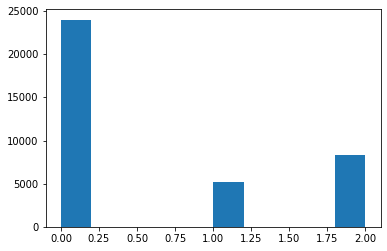

In [0]:
import matplotlib.pyplot as plt

plt.hist(y)
plt.plot()

A partir de la librería `sklearn` podemos separar en dos conjuntos disjuntos, conteniendo el 80% de las muestras para el conjunto de entrenamiento y lo restantepara el de validación.

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

El siguiente paso es determinar el número máximo de palabras que se usarán (es decir, las $n$ primeras palabras más frecuentes) y la longitud máxima de cada vector.

In [0]:
from keras.preprocessing.text import Tokenizer

Using TensorFlow backend.


In [0]:
NUMBER_OF_WORDS = 20000
MAX_LEN = 100

tokenizer = Tokenizer(num_words = NUMBER_OF_WORDS)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

Después, para aquellas frases que tengan palabras que no sean de las más frecuentes, se realiza la técnica de `padding` rellenando con ceros aquellas palabras que no sean tan frecuentes y no aparecen.


In [0]:
from keras.preprocessing.sequence import pad_sequences

X_train = pad_sequences(X_train, padding='post', maxlen=MAX_LEN)
X_test = pad_sequences(X_test, padding='post', maxlen=MAX_LEN)

## Generar el modelo de Red Neuronal Recurrente

In [0]:
VOCABULARY_SIZE = NUMBER_OF_WORDS
EMBEDDING_SIZE = 128

In [0]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(VOCABULARY_SIZE, 
                                    EMBEDDING_SIZE, 
                                    input_shape=(X_train.shape[1],)))

model.add(tf.keras.layers.LSTM(units=128, activation='tanh'))

#En units, se debe especificar cuantas clases tenemos. 
model.add(tf.keras.layers.Dense(units=numpy.unique(y_train).shape[0], 
                                activation='sigmoid'))

model.compile(optimizer='rmsprop', 
                loss='sparse_categorical_crossentropy', 
                metrics=['sparse_categorical_accuracy'])
  
model.summary()

model.fit(X_train, y_train, epochs=3, batch_size=128)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 128)          2560000   
_________________________________________________________________
lstm (LSTM)                  (None, 128)               131584    
_________________________________________________________________
dense (Dense)                (None, 3)                 387       
Total params: 2,691,971
Trainable params: 2,691,971
Non-trainable params: 0
_________________________________________________________________
Train on 29941 samples
Epoch 1/3
29941/29941 [==============================] - 107s 4ms/sample - loss: 0.8960 - sparse_categorical_accuracy: 0.6398
Epoch 2/3
29941/29941 [==============================] - 104s 3ms/sample - loss: 0.8919 - sparse_categorical_accuracy: 0.6417
Epoch 3/3
29941/29941 [==============================] - 104s 3ms/sample - loss: 0.8915 - sparse_cate

In [0]:
test_loss, test_acurracy = model.evaluate(X_test, y_test)
print("Test accuracy: {}".format(test_acurracy))

7486/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

![Overfitting](https://drive.google.com/file/d/1sSIjKl_mWktQHsMzxbc2gD-TOHVaokpH)
